In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn import preprocessing
from sklearn import utils

In [2]:
df = pd.read_csv(r"E:\KARE\Sem 6\PAD\Credit Card Fraud Detection\card_transdata (1).csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
df.info()
df.isnull().values.any()
df["fraud"].describe()
df['fraud'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


0.0    912597
1.0     87403
Name: fraud, dtype: int64

In [4]:
df_missing_columns = (round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
distance_from_home,0.0
distance_from_last_transaction,0.0
ratio_to_median_purchase_price,0.0
repeat_retailer,0.0
used_chip,0.0
used_pin_number,0.0
online_order,0.0
fraud,0.0


In [6]:
genuine = df[df.fraud == 0]
fraud = df[df.fraud == 1]
print(genuine.shape)
print(fraud.shape)

(912597, 8)
(87403, 8)


In [7]:
genuine_sample = genuine.sample(n=87403)
new_df = pd.concat([genuine_sample, fraud], axis=0)
new_df['fraud'].value_counts()

0.0    87403
1.0    87403
Name: fraud, dtype: int64

Number of Genuine transactions:  87403
Number of Fraud transactions:  87403
Percentage of Fraud transactions: 50.0000


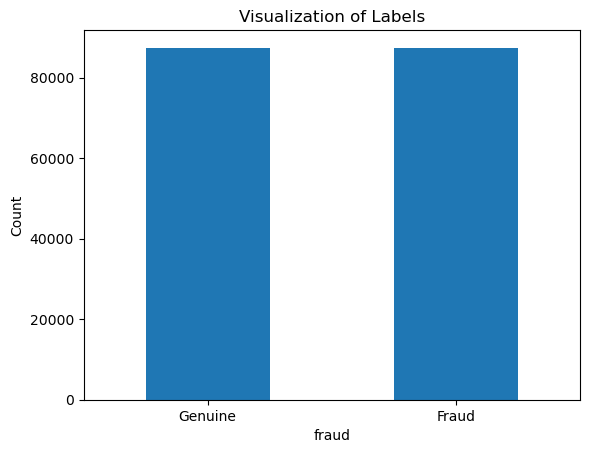

In [8]:
genuine_sample = len(new_df[new_df.fraud == 0])
fraud = len(new_df[new_df.fraud == 1])
fraud_percent = (fraud / (fraud + genuine_sample)) * 100
print("Number of Genuine transactions: ", genuine_sample)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Fraud transactions: {:.4f}".format(fraud_percent))
labels = ["Genuine", "Fraud"]
count_classes = new_df.value_counts(new_df['fraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [9]:
X = new_df.drop(["fraud"], axis= 1)
Y = new_df["fraud"]

In [10]:
X.head()
Y.head()

674236    0.0
976293    0.0
960405    0.0
392571    0.0
979396    0.0
Name: fraud, dtype: float64

In [11]:
(train_X, test_X, train_Y, test_Y) = train_test_split(X, Y, test_size= 0.3, random_state= 42)
print("Shape of train_X: ", train_X.shape)
print("Shape of test_X: ", test_X.shape)

Shape of train_X:  (122364, 7)
Shape of test_X:  (52442, 7)


In [12]:
df_missing_columns = (round(((new_df.isnull().sum()/len(new_df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
distance_from_home,0.0
distance_from_last_transaction,0.0
ratio_to_median_purchase_price,0.0
repeat_retailer,0.0
used_chip,0.0
used_pin_number,0.0
online_order,0.0
fraud,0.0


In [13]:
def fitness_func(individual, X_train):
    # Get the indices of the selected features
    feature_indices = [i for i, x in enumerate(individual) if x == 1]
    # Select the features from the training set
    X_train_selected = train_X
    # Compute the sum of the selected feature columns
    return X_train_selected.sum().sum()

In [14]:
POP_SIZE = 50
GENE_LENGTH = new_df.shape[1] - 1
CROSS_RATE = 0.8
MUTATION_RATE = 0.1
N_GENERATIONS = 100
population = np.random.randint(2, size=(POP_SIZE, GENE_LENGTH))

In [15]:
for generation in range(N_GENERATIONS):
    # Compute the fitness of each individual
    fitness_values = np.array([fitness_func(individual, train_X) for individual in population])
    # Select the fittest individuals for mating
    selected_indices = np.random.choice(range(POP_SIZE), size=POP_SIZE, replace=True, p=fitness_values/fitness_values.sum())
    selected_population = population[selected_indices]
    # Apply crossover to produce offspring
    offspring_population = selected_population.copy()
    for i in range(0, POP_SIZE-1, 2):
        if np.random.rand() < CROSS_RATE:
            cross_point = np.random.randint(0, GENE_LENGTH)
            offspring_population[i, cross_point:] = selected_population[i+1, cross_point:]
            offspring_population[i+1, cross_point:] = selected_population[i, cross_point:]
    # Apply mutation to the offspring
    for i in range(POP_SIZE):
        if np.random.rand() < MUTATION_RATE:
            mutate_point = np.random.randint(0, GENE_LENGTH)
            offspring_population[i, mutate_point] = 1 - offspring_population[i, mutate_point]
    # Replace the old population with the offspring population
    population = offspring_population

In [16]:
fitness_values = np.array([fitness_func(individual, train_X) for individual in population])
fittest_index = np.argmax(fitness_values)
fittest_individual = population[fittest_index]
# Print the selected features and their column sums
selected_features = [i for i, x in enumerate(fittest_individual) if x == 1]
X_train_selected = train_X.iloc[:, selected_features]
print('Selected features:', selected_features)
print('Feature column sums:', X_train_selected.sum())

Selected features: [0, 4, 6]
Feature column sums: distance_from_home    5.441593e+06
used_chip             3.760500e+04
online_order          9.609900e+04
dtype: float64


In [17]:
train_X.fillna(train_X.mean(), inplace=True)
train_Y.fillna(train_Y.mean(), inplace=True)

In [18]:
lab = preprocessing.LabelEncoder()
train_Y_new = lab.fit_transform(train_Y)

In [19]:
logmodel = LogisticRegression()
logmodel.fit(train_X, train_Y)
logmodel_predict = logmodel.predict(test_X)
logmodel_score = logmodel.score(test_X, test_Y)

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_X, train_Y_new)
predictions_dt = decision_tree.predict(test_X)
decision_tree_score = decision_tree.score(test_X, test_Y) * 100

In [21]:
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(train_X, train_Y_new)
predictions_rf = random_forest.predict(test_X)
random_forest_score = random_forest.score(test_X, test_Y) * 100

In [22]:
print("Logistic Regression Score: ", logmodel_score)
print("Random Forest Score: ", random_forest_score)
print("Decision Tree Score: ", decision_tree_score)

Logistic Regression Score:  0.9416688913466306
Random Forest Score:  99.99046565729759
Decision Tree Score:  99.98665192021662


In [23]:
def metrics(actuals, predictions):
    print("Accuracy: {:.5f}".format(accuracy_score(actuals, predictions)))
    print("Precision: {:.5f}".format(precision_score(actuals, predictions,average='weighted')))
    print("Recall: {:.5f}".format(recall_score(actuals, predictions,average='weighted')))
    print("F1-score: {:.5f}".format(f1_score(actuals, predictions,average='weighted')))
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix - Decision Tree
[[26224     7]
 [    0 26211]]
Confusion matrix, without normalization


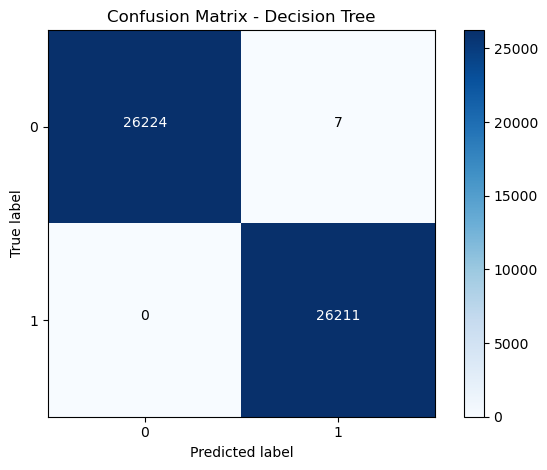

In [24]:
confusion_matrix_dt = confusion_matrix(test_Y, predictions_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt)
plot_confusion_matrix(confusion_matrix_dt, classes=[0, 1], title= "Confusion Matrix - Decision Tree")

Confusion Matrix - Random Forest
[[26226     5]
 [    0 26211]]
Confusion matrix, without normalization


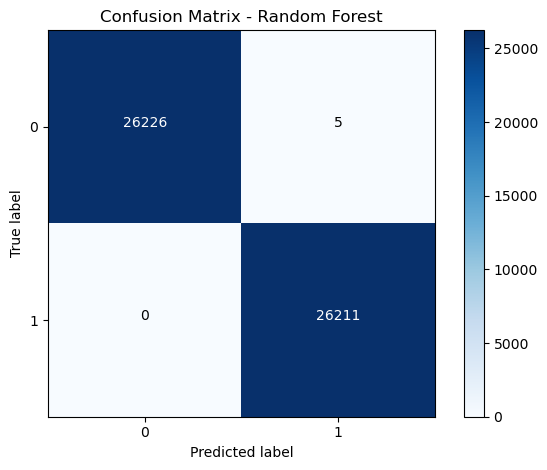

In [25]:
confusion_matrix_rf = confusion_matrix(test_Y, predictions_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)
plot_confusion_matrix(confusion_matrix_rf, classes=[0, 1], title= "Confusion Matrix - Random Forest")

In [26]:
lab = preprocessing.LabelEncoder()
test_Y_new = lab.fit_transform(test_Y)

In [27]:
#Evaluation  of Logistic Regression Model
print("Evaluation of Logistic Regression Model")
print()
metrics(test_Y_new, logmodel_predict)
print()
#Evaluation  of Decision tree Model
print("Evaluation of Decision Tree Model")
print()
metrics(test_Y_new, predictions_dt.round())
print()
#Evaluation of Random forest Model
print("Evaluation of Random Forest Model")
print()
metrics(test_Y_new, predictions_rf.round())

Evaluation of Logistic Regression Model

Accuracy: 0.94167
Precision: 0.94179
Recall: 0.94167
F1-score: 0.94166

Evaluation of Decision Tree Model

Accuracy: 0.99987
Precision: 0.99987
Recall: 0.99987
F1-score: 0.99987

Evaluation of Random Forest Model

Accuracy: 0.99990
Precision: 0.99990
Recall: 0.99990
F1-score: 0.99990


In [28]:
Y_new_pred = random_forest.predict([[57.89,100.567,1233.34,1,0,1,1]])
print("Detection: ",Y_new_pred)
if Y_new_pred == 0:
  print("It's a Genuine Transaction")
else:
  print("It's a Fraud Transaction")

Detection:  [1]
It's a Fraud Transaction


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
import pickle
with open('E:\KARE\Sem 6\PAD\Credit Card Fraud Detection\Model\RF_Model.pkl', 'wb') as model_file:
    pickle.dump(random_forest, model_file)
